# Project I: Parameter estimation for a toy model of an effective field theory
## Learning from data [TIF285], Chalmers, Fall 2022

Last revised: 3-Sep-2022 by Christian Forssén [christian.forssen@chalmers.se]

## Instructions

- See deadline on the course web page
- This project is performed in groups of two students. 
- The second part of the project is optional. See examination rules on the course web page.
- Hand-in your written report and your solution source code via Canvas.
- Students are allowed to discuss together and help each other when working on the projects. However, every student must understand and be able to explain their submitted solutions. Plagiarism (of text and/or code) is not allowed (submissions will be both manually and automatically monitored).

### Written report
- Page limit: 6 pages (excluding title page and list of references). 3 extra pages are allowed when doing also the optional extra task.
- Give a short description of the nature of the problem and the methods you have used.
- Include your results either in figure or tabular form. All tables and figures should have relevant captions and labels on the axes.
- Try to give an interpretation of you results.
- Upload the source code of your program as a separate file (.ipynb or .py). Comment your program properly.

## Main task
The overall project goal is to reproduce various results in a paper: [*Bayesian parameter estimation for effective field theories*](https://arxiv.org/abs/1511.03618) by Sarah Wesolowski, et al.  It's a long paper, so don't try to read all of it!  We'll guide you to the important parts. Sec. II of the paper is the most relevant, but you don't need to understand all of it. 

The paper uses a toy model to simulate an effective field theory (EFT), namely a Taylor series of some specified function. A specific aim is to present guidelines for parameter estimation in the situation where you have some knowledge of the model that can be used in a Bayesian way. We will not discuss the EFT concept in any detail, but will just mention that it is a type of approximation, or effective theory, for a more fundamental (underlying) physical theory. An EFT starts from the relevant degrees of freedom to describe physical phenomena occurring at a chosen length scale or energy scale, while not resolving substructure and degrees of freedom at shorter distances (or, equivalently, at higher energies). 

In our case, the function
$$
g(x) = \left(\frac12 + \tan\left(\frac{\pi}{2}x\right)\right)^2
$$
represents the true, underlying theory.  Its Taylor series at $x=0$ is
$$
g(x) = 0.25 + 1.57 x + 2.47 x^2 + 1.29 x^3 + \cdots
$$
where the expansion parameters are known in this toy example (since we know the underlying theory), but would not be in a real situation.

Our "effective theory" then corresponds to the expansion
$$
g_{\rm th}(x) \equiv \sum_{i=0}^k a_i x^i,
$$
where $a_i$ are the parameters. For an EFT, these are sometimes known as low-energy constants (LECs).

Your general task is to fit the parameters $a_i$, up to some truncation order $k$, using a Bayesian approach, and analyze the results. 

* **Your specific goal is to reproduce and interpret Figure 1 on page 6 of the arXiv preprint. This figure shows joint pdfs for the EFT parameters using two different priors. One of these priors encapsulates the physics expectation that the parameters should be of "natural" size (order one).**
* **A secondary goal is to reproduce Figs. 3 and 4 that show predictions of the inferred EFT with error bands. You can either use $k=k_\mathrm{max}=3$ as in the first task, or $k=k_\mathrm{max}=4$ as in the preprint.** 

You should use emcee to sample the joint pdfs and you should use corner to make plots.

In [58]:
# imports
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from corner import corner
import emcee
from sklearn.ensemble import GradientBoostingRegressor

In [59]:
x = np.array([0.03183,0.06366,0.09549,0.12732,0.15915,0.19099,0.22282,0.25465,0.28648,0.31831])
d = np.array([0.31694,0.33844,0.42142,0.57709,0.56218,0.68851,0.73625,0.87270,1.0015,1.0684])
s = np.array([0.01585,0.01692,0.02107,0.02885,0.02811,0.03443,0.03681,0.04364,0.050075,0.05342])

## Task 1

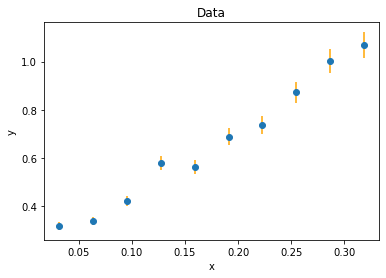

In [60]:
# data scouting
plt.errorbar(x,d,s, fmt='o', ecolor='orange')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data')
plt.show()

In [61]:
def log_flat_prior(a):
    if np.all(np.abs(a) < 1000):
        return 0 # log(1)
    else:
        return -np.inf  # log(0)
    
def log_naturalness_prior(a):
    a_bar = 5
    cte = 1/(a_bar*(np.pi*2)**0.5)**5
    norm_a = np.sum(a*a)
    exp = np.exp(-norm_a/(2*a_bar**2))
    np.seterr(divide = 'ignore') 
    resp=np.log(cte*exp)
    np.seterr(divide = 'warn') 
    return resp

In [62]:
def log_likelihood(a, x, y, dy=s):
    '''
    Returns the log likelihood.
    
    Args:
        theta: array of floats with two elements. theta[0]=intercept. theta[1]=slope
        x: data (independent variable). array of floats
        y: data (dependent variable). array of floats
        dy: fixed error (optional; default=50), standard deviation of a normal distribution
        
    Returns:
        logL: log likelihood
    '''
    # YOUR CODE HERE
    y_model = a[3]*x**3 + a[2]*x**2 + a[1]*x + a[0]
    logL=-0.5 * np.sum(np.log(2 * np.pi * dy**2) + (y - y_model)**2 / dy**2)
    return logL

In [63]:
def contour_levels(grid):
    """Compute 1, 2, 3-sigma contour levels for a gridded 2D posterior"""
    _sorted = np.sort(grid.ravel())[::-1]
    pct = np.cumsum(_sorted) / np.sum(_sorted)
    cutoffs = np.searchsorted(pct, np.array([0.68, 0.95, 0.997]) ** 2)
    return np.sort(_sorted[cutoffs])

def log_posterior(theta, x, y, flat=True):
    if flat:
        return log_flat_prior(theta) + log_likelihood(theta, x, y)
    else:
        return log_naturalness_prior(theta) + log_likelihood(theta, x, y)
    
def minimize_log_posterior (theta,x,y,flat=True):
    return -log_posterior(theta, x, y, flat=flat)

In [64]:
def design_matrix(x, degree=2):
    X_d = np.zeros((x.shape[0],degree+1))
    for i in range(0,degree+1):
        X_d[:,i] = x**i
    return X_d

def sampler(flat=True):
    min_theta=np.array([-100,-100,-100,-100])
    max_theta=np.array([100,100,100,100])

    ndim = 4  # number of parameters in the model
    nwalkers = 50  # number of MCMC walkers
    nburn = 1000  # "burn-in" period to let chains stabilize
    nsteps = 1000  # number of MCMC steps to take

    # we'll start at random locations within the prior volume
    starting_guesses = min_theta + max_theta * np.random.rand(nwalkers,ndim)
    

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x,d, flat))

    # "burn-in" period; save final positions and then reset
    pos, prob, state = sampler.run_mcmc(starting_guesses, nburn)
    sampler.reset()

    # sampling period
    sampler.run_mcmc(pos, nsteps)

    # discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, ndim)
    samples = sampler.chain.reshape((-1, ndim))
    return samples

def predict(samples, k):
    x = np.linspace(0, 0.4, num=100)
    de = design_matrix(x,degree=k-1)
    predictions = samples.dot(de.T)
    
    median_prediction = np.median(predictions,axis=0)
    sigma_prediction = np.std(predictions,axis=0)
    confidence_interval_prediction = (median_prediction-sigma_prediction, median_prediction+sigma_prediction)
    
    return median_prediction, confidence_interval_prediction, sigma_prediction

def true_function(x):
    return (0.5 + np.tan(np.pi*x/2))**2
    

In [65]:
samples=sampler(flat=False)

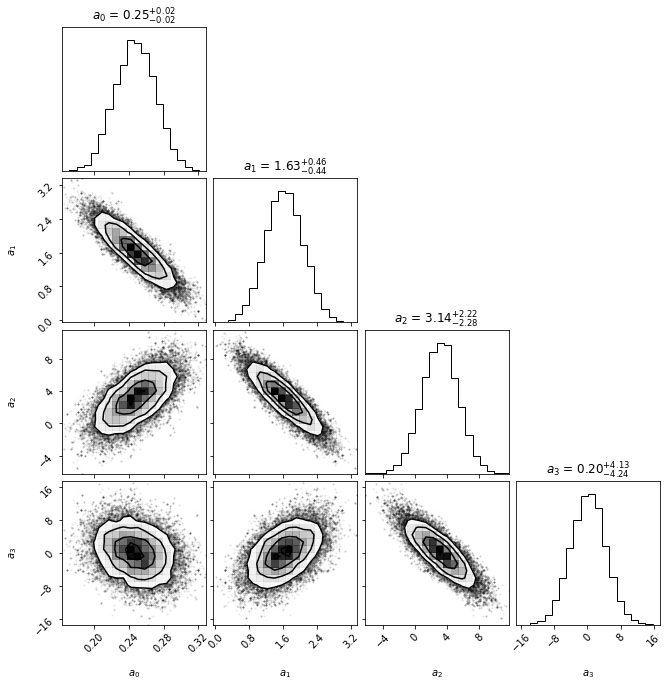

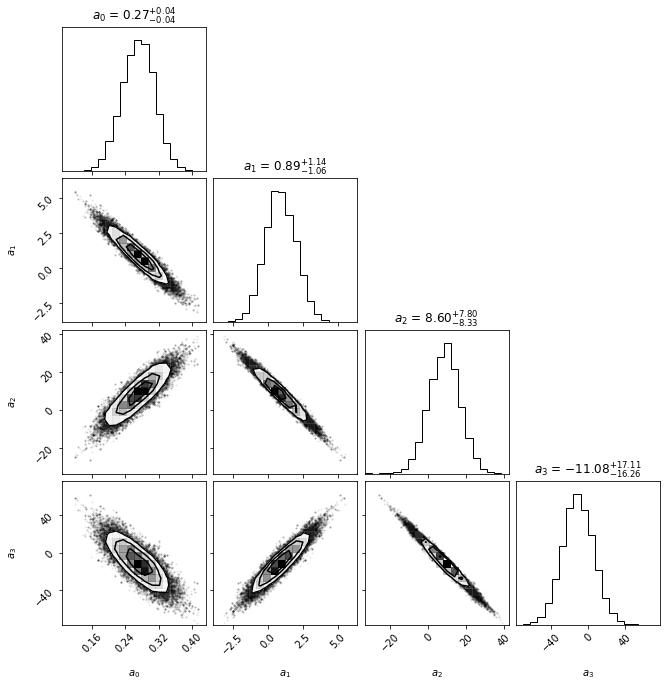

In [66]:
corner(samples, labels=["$a_0$" , "$a_1$", "$a_2$", "$a_3$"], show_titles=True)
corner(sampler(flat=True),labels=["$a_0$" , "$a_1$", "$a_2$", "$a_3$"], show_titles=True)
plt.show()

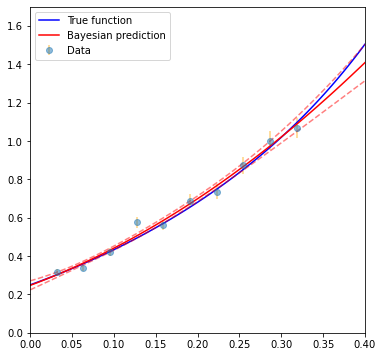

In [67]:
# bayesian prediction
x_range = np.linspace(0, 0.4, 100)
median, confidence_interval, ss = predict(samples,k=4)

plt.figure(figsize=(6,6))
ax=plt.subplot(111)
sns.lineplot(x=x_range, 
             y=[true_function(i) for i in x_range], 
             color='b', 
             label='True function',
             ax=ax)
sns.lineplot(x=x_range,
             y=median,
             color='r',
             label='Bayesian prediction',
             ax=ax)
sns.lineplot(x=x_range,
             y=confidence_interval[0],
             color='r',
             alpha=0.5,
             linestyle='--',
             ax=ax)
sns.lineplot(x=x_range,
             y=confidence_interval[1],
             color='r',
             alpha=0.5,
             linestyle='--',
             ax=ax)
ax.errorbar(x,
            d,
            s, 
            alpha=0.5,
            fmt='o', 
            ecolor='orange',
            label='Data')
plt.legend()
plt.xlim(0,0.4)
plt.ylim(0,1.7)
plt.show()

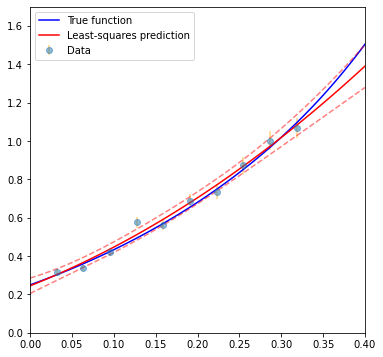

In [73]:
# least-squares prediction
x_range = np.linspace(0, 0.4, 100)
lin_reg = LinearRegression()
lin_reg.fit(design_matrix(x,degree=3),d)
stdev = np.sqrt(sum((lin_reg.predict(design_matrix(x,degree=3)) - d)**2) / (len(d) - 2))

plt.figure(figsize=(6,6))
ax=plt.subplot(111)
sns.lineplot(x=x_range, 
             y=[true_function(i) for i in x_range], 
             color='b', 
             label='True function',
             ax=ax)
sns.lineplot(y=lin_reg.predict(design_matrix(x_range,degree=3)),
             x=x_range,
             color='r',
             label='Least-squares prediction',
             ax=ax)
sns.lineplot(x=x_range,
             y=lin_reg.predict(design_matrix(x_range,degree=3))+ss+stdev/2,
             color='r',
             alpha=0.5,
             linestyle='--',
             ax=ax)
sns.lineplot(x=x_range,
             y=lin_reg.predict(design_matrix(x_range,degree=3))-ss-stdev/2,
             color='r',
             alpha=0.5,
             linestyle='--',
             ax=ax)
ax.errorbar(x,
            d,
            s, 
            alpha=0.5,
            fmt='o', 
            ecolor='orange',
            label='Data')
plt.legend()
plt.xlim(0,0.4)
plt.ylim(0,1.7)
plt.show()

### Learning goals:
* Apply and extend the Bayesian parameter estimation ideas and techniques from the course.
* This a less-guided set of tasks and you will have to put together ideas and tools we've discussed.
* Explore the impact of control features:  dependence on how much data is used and how precise it is; apply an *informative* prior.
* Learn about some diagnostics for Bayesian parameter estimation.
* Try out sampling on a controlled problem.

### Suggestions for how to proceed:
* Follow the lead of the exercise notebooks.
* Load the data set that was used in the paper: [D1_c_5.dat](https://arxiv.org/src/1511.03618v3/anc/D1_c_5.dat). The three columns correspond respectively to $x_j$, the measured data $d(x_j) \equiv d_j$ and the error in terms of a standard deviation $\sigma_j$.
* Define functions for the two choices of prior: a wide uniform prior, e.g. $|a_i|<100$, and a Gaussian naturalness prior given by Eq. (24) with $\bar{a}=5$. Use the log prior.
* Define a function for the likelihood (Eq. 9). It will require the chi-squared measure. Use the log likelihood.
* Call emcee to sample the posteriors. 
* Use corner to create plots.  You can read the answers for the tables from the corner plots.
* Don't try to do too much in your code at first (start with a low order). 
* Generate figures for the lowest orders analogous to Figure 1 and then reproduce Figure 1.


### Comments and suggestions
* The `show_titles=True` option to corner will show central results and one-$\sigma$ error limits on the projected posterior plots.
* The `quantiles=[0.16, 0.5, 0.84]`option to corner adds the dashed vertical lines to the marginal posteriors on the diagonal. You can obviously change the quantiles if you want another credibility region.
* The python command `np.percentile(y, [16, 50, 84], axis=0)` might be useful to extract numerical values for the credibility region and the median from a python array `y`.
* When reproducing Figures 3 and 4 you can use Matplotlib's `fill_between(x, y-error, y+error)` to make bands.  (Use the `alpha` keyword for `fill_between`, e.g., `alpha=0.5`, to make the bands more transparent.)

## Optional: Part 2 (extra task)
* Reproduce and interpret Table III on page 12 of the arXiv preprint. 
* Repeat the analysis with the same function but different data precision and/or quantity (number of data points). You will then have to generate the data yourself using Eq. (2) and the true function Eq. (23). It is probably wise to stay in the $0 < x \le 1/\pi$ range.